# Implementing Canny Edge Detection

In [1]:
# Author : Sukhmeet Singh
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from skimage import data, color
from skimage.feature import canny
from skimage.io import imread
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

## Helper Functions
- Function to plot
- Adds padding to image
- Convolve two matrix


In [2]:
# function to display the images
def display(image, text=["NONE"]):
    if len(image)==1:
        figure(figsize=(8, 6), dpi=80)
        plt.imshow(image[0], cmap="gray")
        plt.title(text[0])
        plt.show()
        return
        
    fig, axes = plt.subplots(1, ncols=len(image), figsize=(16, 8))
    txt = "text to be displayed"

    for img in range(len(image)):
        axes[img].imshow(image[img],cmap="gray")
        axes[img].axis('off')
        if img >= len(text):
            txt = "NONE"
        else:
            txt = text[img]
        axes[img].set_title(txt)
    plt.show()

In [3]:
# adds padding to image
def padding_image(image,padd_size):
    img = np.pad(image, (padd_size, padd_size), 'edge')
    return img

In [4]:
# convolution function
def convolve(image,kernel,sigma):
    img=np.full(image.shape,0.0)
    # flatten the kernel     
    kernel_patch = kernel.flatten()
    for i in range(sigma, img.shape[0]-sigma):
        for j in range(sigma, img.shape[1]-sigma):

            # flatten the image and kernel
            img_patch = image[i-sigma:i+sigma+1, j-sigma:j+sigma+1].flatten()
            img[i, j] = np.sum(img_patch*kernel_patch)
            
    return img

## Gaussian filter to remove noise from the image

In [5]:
def GaussianFilter(image, sigma):
    img=np.copy(image)

    # padding the image 
    img = padding_image(img,sigma)

    # kernel 
    kernel = np.zeros((2*sigma+1, 2*sigma+1))
    for i in range(2*sigma+1):
        for j in range(2*sigma+1):
            kernel[i, j] = np.exp(-((i-sigma)**2 + (j-sigma)**2)/(2*sigma**2))*(1/(2*np.pi*sigma**2))
    kernel = kernel/np.sum(kernel)
    
    # convolve the image with the kernel
    img = convolve(img,kernel,sigma)

    # remove the padding
    return img[sigma:img.shape[0]-sigma, sigma:img.shape[1]-sigma]

## Calculate sobel filter in x and y direction

In [6]:
def sobelFilter(image):
    sobel_x=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    sobel_y=np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    img=np.copy(image)

    sigma=1
    
    # padding the image
    img = padding_image(img,sigma)

    # convolve the image with the kernel
    img_x = convolve(img,sobel_x,sigma)
    img_y = convolve(img,sobel_y,sigma)

    # remove the padding
    return img_x[sigma:img.shape[0]-sigma, sigma:img.shape[1]-sigma], img_y[sigma:img.shape[0]-sigma, sigma:img.shape[1]-sigma]

## Calculating magnitude and angle using the output of sobel

In [7]:
def gradientCalculation(image_x, image_y):
    gradient_magnitude=np.hypot(image_x,image_y)
    angle=np.arctan2(image_y,image_x)*180/np.pi
    return gradient_magnitude,angle

## Removing extra pixels by only considering values in right direction

In [8]:
# suppessing the non-maximum pixels
def nonMaxSuppression(gradient,angle):
    newImage=np.zeros(gradient.shape)

    neighbour1=0
    neighbour2=0
    angle[angle<0]+=180
    for i in range(1,gradient.shape[0]-1):
        for j in range(1,gradient.shape[1]-1):

                ang=abs(angle[i,j])
                
                if ang<=22.5 or ang>157.5:
                    neighbour1=gradient[i,j-1]
                    neighbour2=gradient[i,j+1]
                elif ang>22.5 and ang<=67.5:
                    neighbour1=gradient[i-1,j-1]
                    neighbour2=gradient[i+1,j+1]
                elif ang>67.5 and ang<=112.5:
                    neighbour1=gradient[i-1,j]
                    neighbour2=gradient[i+1,j]
                elif ang>112.5 and ang<=157.5:
                    neighbour1=gradient[i-1,j+1]
                    neighbour2=gradient[i+1,j-1]
                if gradient[i,j]>=neighbour1 and gradient[i,j]>=neighbour2:
                    newImage[i,j]=gradient[i,j]
                else:
                    newImage[i,j]=0
    return newImage

## Double thresholding

In [9]:
def threshold(image,lowThreshold,highThreshold):

    newImage=np.zeros(image.shape)
    # indices of strong edges and weak edges
    strong_x,strong_y=np.where(image>=highThreshold)
    weak_x,weak_y=np.where((image<=highThreshold) & (image>=lowThreshold))

    newImage[strong_x,strong_y]=255
    newImage[weak_x,weak_y]=50

    return newImage

## Hysteresis 

In [10]:
def hysteresis(image,lowThreshhold=50,highThreshold=255):
    newImage=np.zeros(image.shape)
    
    for x in range(1,image.shape[0]-1):
        for y in range(1,image.shape[1]-1):
            if image[x,y]==lowThreshhold:
                if (image[x+1,y-1]==highThreshold or image[x+1,y]==highThreshold or image[x+1,y+1]==highThreshold or image[x,y-1]==highThreshold or image[x,y+1]==highThreshold or image[x-1,y-1]==highThreshold or image[x-1,y]==highThreshold or image[x-1,y+1]==highThreshold):
                    newImage[x,y]=highThreshold
                else:
                    newImage[x,y]=0
            else:
                newImage[x,y]=image[x,y]
    return newImage

In [11]:
def myCannyEdgeDetector(image, sigma=1,Low_Threshold=0.1, High_Threshold=0.2):
    #  apply Gaussian filter 
    imageBLur = GaussianFilter(image, sigma=sigma)

    # applying sobel filter in x and y direction
    image_x, image_y = sobelFilter(imageBLur)

    # gradient calculation
    gradient_magnitude, angle = gradientCalculation(image_x, image_y)

    # applying non-maximum suppression
    image_after_nonMaxSuppression = nonMaxSuppression(gradient_magnitude, angle)

    # thresholding
    Low_Threshold = Low_Threshold * image_after_nonMaxSuppression.max()
    High_Threshold = High_Threshold * image_after_nonMaxSuppression.max()
    exract_strong_edges= threshold(image_after_nonMaxSuppression, Low_Threshold, High_Threshold)

    # eliminating the extra weak edges
    final_edge_map = hysteresis(exract_strong_edges)
    
    # converting to binary image
    final_edge_map=255==final_edge_map

    return final_edge_map,Low_Threshold,High_Threshold

# Running 

## Running My Canny Edge Detector

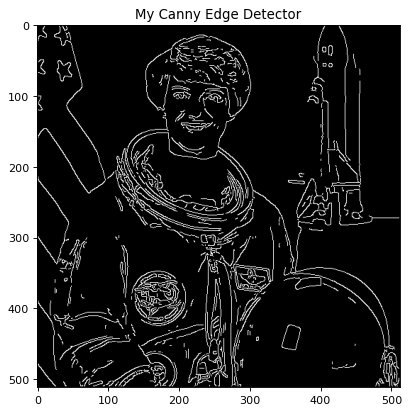

In [12]:
# Load the image : astrounat image
image=data.astronaut()

# convert the image to grayscale
image = color.rgb2gray(image)
sigma=1
Low_Threshold=0.1
High_Threshold=0.15
# call my canny edge detector
my_edge_map,Low_Threshold,High_Threshold=myCannyEdgeDetector(image,sigma=sigma,Low_Threshold=Low_Threshold, High_Threshold=High_Threshold)

# displaying
display([my_edge_map], ["My Canny Edge Detector"])

## Running Skimage Canny Edge Detector

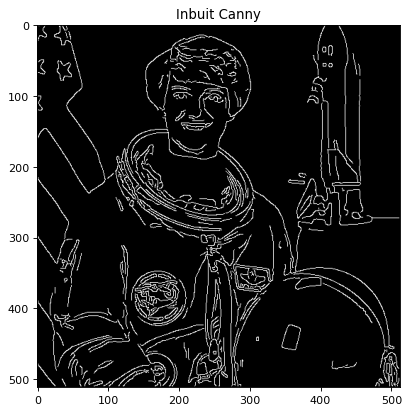

In [13]:
# call the canny edge detector from the skimage library
inbuilt_canny_edge_detector=canny(image, sigma=sigma, low_threshold=Low_Threshold, high_threshold=High_Threshold)

display([inbuilt_canny_edge_detector], ["Inbuit Canny"])


## Comparing Both

PSNR value is:  18.004918252395687
SSIM value is:  0.9152422102367312


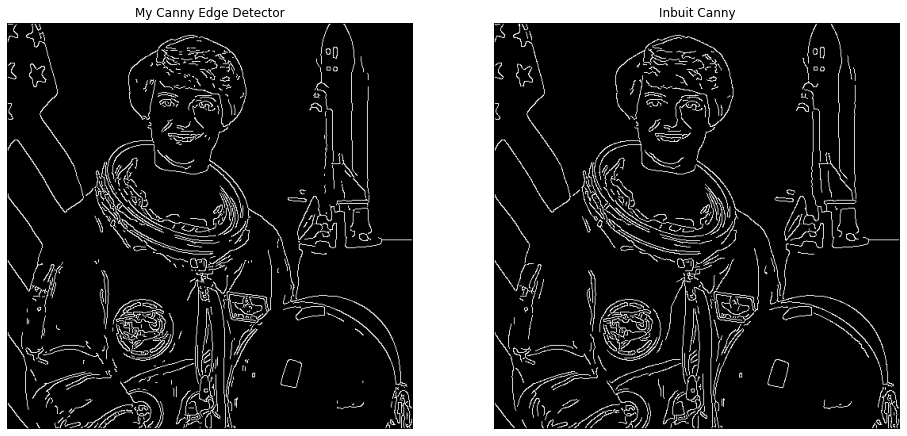

In [14]:
# psnr value
print("PSNR value is: ",psnr(inbuilt_canny_edge_detector,my_edge_map))

# ssim value
print("SSIM value is: ",ssim(inbuilt_canny_edge_detector,my_edge_map))

# display both images
display([my_edge_map,inbuilt_canny_edge_detector], ["My Canny Edge Detector","Inbuit Canny"])